# Using GPT to implement a Convolutional Neural Networks for Satellite image classification. 

Antonio Fonseca

Packages to be installed:

```
conda install -c conda-forge umap-learn
pip install phate
conda install -c conda-forge imageio
pip install wandb
```

In [1]:
import numpy as np
import codecs
import copy
import json
import scipy.io
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
import os
# import phate
# import umap
import pandas as pd 
# import scprep
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
# import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gpfs/gibbs/project/dijk/ahf38/conda_envs/geo_comp2/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


cuda


Now that we have an autoencoder working on MNIST, let's use this model to visualize some geodata. For the next section we will use the SAT-6 (https://csc.lsu.edu/~saikat/deepsat/)

# Dataset decription: SAT
SAT-6 consists of a total of 405,000 image patches each of size 28x28 and covering <span style="color:red"> 6 landcover classes - barren land, trees, grassland, roads, buildings and water bodies</span>. 324,000 images (comprising of four-fifths of the total dataset) were chosen as the training dataset and 81,000 (one fifths) were chosen as the testing dataset. Similar to SAT-4, the training and test sets were selected from disjoint NAIP tiles. Once generated, the images in the dataset were randomized in the same way as that for SAT-4. The specifications for the various landcover classes of SAT-4 and SAT-6 were adopted from those used in the National Land Cover Data (NLCD) algorithm. 

The datasets are encoded as MATLAB .mat files that can be read using the standard load command in MATLAB.  <span style="color:red">Each sample image is 28x28 pixels and consists of 4 bands - red, green, blue and near infrared </span>. The training and test labels are 1x4 and 1x6 vectors for SAT-4 and SAT-6 respectively having a single 1 indexing a particular class from 0 through 4 or 6 and 0 values at all other indices.

The MAT file for the SAT-6 dataset contains the following variables:

- train_x	28x28x4x324000 uint8 (containing 324000 training samples of 28x28 images each with 4 channels)
- train_y	324000x6 uint8 (containing 6x1 vectors having labels for the 324000 training samples)
- test_x	28x28x4x81000 uint8 (containing 81000 test samples of 28x28 images each with 4 channels)
- test_y	81000x6 uint8 (containing 6x1 vectors having labels for the 81000 test samples)

Labels:
- Building = 0
- Barren_land = 1
- Tree=2
- Grassland=3
- Road = 4
- Water = 5


# Accessing GPT-4
We will be using [Perplexity](https://www.perplexity.ai/) to ask GPT to create code for us. You can create a free account. 

## [Prompt](https://www.perplexity.ai/search/368ba448-d6b3-4973-b00b-2950a9128947?s=c): "Can you make me the pytorch implementation of a CNN to classify the sat-6-full dataset"

Access the link above to see the full conversation. After a few back and forth iterations, we got the code below. 
NOTE: I had to fix the permutation myself to put the data in the shape: (samples, channels, width, heigth)

In [17]:
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Load the SAT-6 dataset
train_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
train_x = torch.from_numpy(train_data['train_x']).float().permute(3, 2, 0, 1)
train_y = torch.from_numpy(train_data['train_y']).float().permute(1, 0)
print('train_x.shape: ',train_x.shape)
print('train_y.shape: ',train_y.shape)

test_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
test_x = torch.from_numpy(test_data['test_x']).float().permute(3, 2, 0, 1)
test_y = torch.from_numpy(test_data['test_y']).float().permute(1, 0)

# Define the data transformations. 
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512) #To fix the code, change this to 128*3*3 instead of (128 * 16 * 16)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3) # To fix this line, just use 128*3*3 instead of 128*16*16
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN and define the loss function and optimizer
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

# Test the CNN
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

train_x.shape:  torch.Size([324000, 4, 28, 28])
train_y.shape:  torch.Size([324000, 6])
Epoch 1 loss: 0.114
Epoch 2 loss: 0.063
Epoch 3 loss: 0.055
Epoch 4 loss: 0.047
Epoch 5 loss: 0.045


KeyboardInterrupt: 

Note that the `transform` operation is not being used. This is the because the `TensorDataset` doesn't accept a transformation to normalize the data. GPT made a mistake here. We could fix it or keep asking it to fix... So let's just fix it for now. Note how slowly it is though. 

I asked GPT to make it run in GPU:
## Prompt: Can you make this code run in GPU? 
Here is what I got (after applying the fixes done above):

In [18]:
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Load the SAT-6 dataset
train_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
train_x = torch.from_numpy(train_data['train_x']).float().permute(3, 2, 0, 1)
train_y = torch.from_numpy(train_data['train_y']).float().permute(1, 0)

test_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
test_x = torch.from_numpy(test_data['test_x']).float().permute(3, 2, 0, 1)
test_y = torch.from_numpy(test_data['test_y']).float().permute(1, 0)

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN and define the loss function and optimizer
cnn = CNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))

# Test the CNN
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Epoch 1 loss: 0.097
Epoch 2 loss: 0.058
Epoch 3 loss: 0.048
Epoch 4 loss: 0.044
Epoch 5 loss: 0.041
Epoch 6 loss: 0.041
Epoch 7 loss: 0.036
Epoch 8 loss: 0.037
Epoch 9 loss: 0.039
Epoch 10 loss: 0.036


RuntimeError: The size of tensor a (64) must match the size of tensor b (6) at non-singleton dimension 1

Note that GPT forgot that `labels` is vector. So let's help it

In [21]:
print(predicted.shape)
print(labels.shape)

torch.Size([64])
torch.Size([64, 6])


In [23]:
# Test the CNN
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels,axis=1)).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 99 %


Ok, 99% of accuracy is not bad at all, but if we want to use this trained model, we will want to save checkpoints based on the validation loss. So let's ask GPT to do it

# Prompt: "Can you please save the best checkpoint according to the validation loss during training?"

In [12]:
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import numpy as np

# Load the SAT-6 dataset
train_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
train_x = torch.from_numpy(train_data['train_x']).float().permute(3, 2, 0, 1) #Manual fix 
train_y = torch.from_numpy(train_data['train_y']).float().permute(1, 0)

test_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
test_x = torch.from_numpy(test_data['test_x']).float().permute(3, 2, 0, 1) #Manual fix
test_y = torch.from_numpy(test_data['test_y']).float().permute(1, 0)

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512) # Manual fix 
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3) #Manual fix
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN and define the loss function and optimizer
cnn = CNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define the TensorBoard writer
writer = SummaryWriter()

# Define the ModelCheckpoint callback
best_loss = np.inf
checkpoint_path = './best_model.pth'
checkpoint = {'epoch': None, 'model_state_dict': None, 'optimizer_state_dict': None, 'loss': None}

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print('Epoch %d loss: %.3f' % (epoch + 1, epoch_loss))
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    scheduler.step(epoch_loss)
    with torch.no_grad():
        valid_loss = 0.0
        valid_preds = []
        valid_labels = []
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_preds.extend(predicted.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())
        valid_loss /= len(test_loader)
        valid_acc = accuracy_score(valid_labels, valid_preds) #Original with 
        print('Validation loss: %.3f' % valid_loss)
        print('Validation accuracy: %.3f' % valid_acc)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('Accuracy/valid', valid_acc, epoch)
        if valid_loss < best_loss:
            best_loss = valid_loss
            checkpoint['epoch'] = epoch
            checkpoint['model_state_dict'] = cnn.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['loss'] = best_loss
            torch.save(checkpoint, checkpoint_path)

# Test the CNN
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels,axis=1)).sum().item()

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Epoch 1 loss: 0.112


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

Once again, GPT forgot to cast the correct type of the variable. Let's correct it for them...
Note: did you notice GPT included a learning rate scheduler without me asking for it? 

In [13]:
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import numpy as np

# Load the SAT-6 dataset
train_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
train_x = torch.from_numpy(train_data['train_x']).float().permute(3, 2, 0, 1) #Manual fix 
train_y = torch.from_numpy(train_data['train_y']).float().permute(1, 0)

test_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
test_x = torch.from_numpy(test_data['test_x']).float().permute(3, 2, 0, 1) #Manual fix
test_y = torch.from_numpy(test_data['test_y']).float().permute(1, 0)

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512) # Manual fix 
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3) #Manual fix
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN and define the loss function and optimizer
cnn = CNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define the TensorBoard writer
writer = SummaryWriter()

# Define the ModelCheckpoint callback
best_loss = np.inf
checkpoint_path = './best_model.pth'
checkpoint = {'epoch': None, 'model_state_dict': None, 'optimizer_state_dict': None, 'loss': None}

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print('Epoch %d loss: %.3f' % (epoch + 1, epoch_loss))
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    scheduler.step(epoch_loss)
    with torch.no_grad():
        valid_loss = 0.0
        valid_preds = []
        valid_labels = []
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_preds.extend(predicted.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())
        valid_loss /= len(test_loader)
        # valid_acc = accuracy_score(valid_labels, valid_preds) #Original with bug 
        valid_acc = accuracy_score(torch.argmax(torch.Tensor(valid_labels),axis=1), valid_preds) #Manual fix
        print('Validation loss: %.3f' % valid_loss)
        print('Validation accuracy: %.3f' % valid_acc)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('Accuracy/valid', valid_acc, epoch)
        if valid_loss < best_loss:
            best_loss = valid_loss
            checkpoint['epoch'] = epoch
            checkpoint['model_state_dict'] = cnn.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['loss'] = best_loss
            torch.save(checkpoint, checkpoint_path)

# Test the CNN
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels,axis=1)).sum().item() ##Manual fix

print('Accuracy on the test set: %d %%' % (100 * correct / total))

Epoch 1 loss: 0.121
Validation loss: 0.066
Validation accuracy: 0.976
Epoch 2 loss: 0.065
Validation loss: 0.045
Validation accuracy: 0.985
Epoch 3 loss: 0.055
Validation loss: 0.048
Validation accuracy: 0.984
Epoch 4 loss: 0.050
Validation loss: 0.038
Validation accuracy: 0.987
Epoch 5 loss: 0.047
Validation loss: 0.049
Validation accuracy: 0.982
Epoch 6 loss: 0.044
Validation loss: 0.036
Validation accuracy: 0.988
Epoch 7 loss: 0.040
Validation loss: 0.044
Validation accuracy: 0.985
Epoch 8 loss: 0.039
Validation loss: 0.152
Validation accuracy: 0.965
Epoch 9 loss: 0.041
Validation loss: 0.048
Validation accuracy: 0.985
Epoch 10 loss: 0.045
Validation loss: 0.053
Validation accuracy: 0.983
Accuracy on the test set: 98 %


It would be nice to have these logs plotted to wandb. Let's ask GPT to do that for us.

## Prompt: Can you log accuracy and loss to wandb during training?

In [ ]:
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import numpy as np
import wandb

# Initialize wandb
# wandb.init(project='my-project-name', entity='my-entity-name') #Original 
wandb.init(project='CNN_with_GPT', entity='ahof1704') #Original 

# Load the SAT-6 dataset
train_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
train_x = torch.from_numpy(train_data['train_x']).float().permute(3, 2, 0, 1) #Manual fix
train_y = torch.from_numpy(train_data['train_y']).float().permute(1, 0)

test_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
test_x = torch.from_numpy(test_data['test_x']).float().permute(3, 2, 0, 1) #Manual fix
test_y = torch.from_numpy(test_data['test_y']).float().permute(1, 0)

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512) # manual fix
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3) # manual fix
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN and define the loss function and optimizer
cnn = CNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define the TensorBoard writer
writer = SummaryWriter()

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print('Epoch %d loss: %.3f' % (epoch + 1, epoch_loss))
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    wandb.log({'Loss/train': epoch_loss})
    scheduler.step(epoch_loss)
    with torch.no_grad():
        valid_loss = 0.0
        valid_preds = []
        valid_labels = []
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_preds.extend(predicted.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())
        valid_loss /= len(test_loader)
        valid_acc = accuracy_score(valid_labels, valid_preds)
        print('Validation loss: %.3f' % valid_loss)
        print('Validation accuracy: %.3f' % valid_acc)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('Accuracy/valid', valid_acc, epoch)
        wandb.log({'Loss/valid': valid_loss, 'Accuracy/valid': valid_acc})

Now GPT removed the script for saving the checkpoints... Come on GPT, you can do better! Let's train again



In [14]:
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import numpy as np
import wandb

# Initialize wandb
wandb.init(project='CNN_with_GPT', entity='ahof1704')

# Load the SAT-6 dataset
train_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
train_x = torch.from_numpy(train_data['train_x']).float().permute(3, 2, 0, 1) #Manual fix
train_y = torch.from_numpy(train_data['train_y']).float().permute(1, 0)

test_data = sio.loadmat('./SAT-4_and_SAT-6_datasets/sat-6-full.mat')
test_x = torch.from_numpy(test_data['test_x']).float().permute(3, 2, 0, 1) #Manual fix
test_y = torch.from_numpy(test_data['test_y']).float().permute(1, 0)

# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create PyTorch datasets and data loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the CNN and define the loss function and optimizer
cnn = CNN().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Define the TensorBoard writer
writer = SummaryWriter()

# Define the ModelCheckpoint callback
best_loss = np.inf
checkpoint_path = './best_model.pth'
checkpoint = {'epoch': None, 'model_state_dict': None, 'optimizer_state_dict': None, 'loss': None}

# Train the CNN
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    print('Epoch %d loss: %.3f' % (epoch + 1, epoch_loss))
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    wandb.log({'Loss/train': epoch_loss})
    scheduler.step(epoch_loss)
    with torch.no_grad():
        valid_loss = 0.0
        valid_preds = []
        valid_labels = []
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_preds.extend(predicted.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())
        valid_loss /= len(test_loader)
        # valid_acc = accuracy_score(valid_labels, valid_preds)
        valid_acc = accuracy_score(torch.argmax(torch.Tensor(valid_labels),axis=1), valid_preds) #Manual fix
        print('Validation loss: %.3f' % valid_loss)
        print('Validation accuracy: %.3f' % valid_acc)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('Accuracy/valid', valid_acc, epoch)
        wandb.log({'Loss/valid': valid_loss, 'Accuracy/valid': valid_acc})
        if valid_loss < best_loss:
            best_loss = valid_loss
            checkpoint['epoch'] = epoch
            checkpoint['model_state_dict'] = cnn.state_dict()
            checkpoint['optimizer_state_dict'] = optimizer.state_dict()
            checkpoint['loss'] = best_loss
            torch.save(checkpoint, checkpoint_path)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahof1704. Use `wandb login --relogin` to force relogin


Epoch 1 loss: 0.115
Validation loss: 0.061
Validation accuracy: 0.978
Epoch 2 loss: 0.063
Validation loss: 0.062
Validation accuracy: 0.979
Epoch 3 loss: 0.054
Validation loss: 0.039
Validation accuracy: 0.985
Epoch 4 loss: 0.047
Validation loss: 0.056
Validation accuracy: 0.984
Epoch 5 loss: 0.045
Validation loss: 0.048
Validation accuracy: 0.983
Epoch 6 loss: 0.041
Validation loss: 0.041
Validation accuracy: 0.987
Epoch 7 loss: 0.041
Validation loss: 0.042
Validation accuracy: 0.988
Epoch 8 loss: 0.044
Validation loss: 0.051
Validation accuracy: 0.983
Epoch 9 loss: 0.040
Validation loss: 0.041
Validation accuracy: 0.987
Epoch 10 loss: 0.037
Validation loss: 0.028
Validation accuracy: 0.991


Ok, let's do some inference on this model now

In [20]:
cnn = CNN().to('cuda')
load_checkpoint=torch.load('./best_model.pth')
cnn.load_state_dict(load_checkpoint['model_state_dict'])

<All keys matched successfully>

t_test.shape:  torch.Size([64, 6])
x_test.shape:  torch.Size([64, 4, 28, 28])


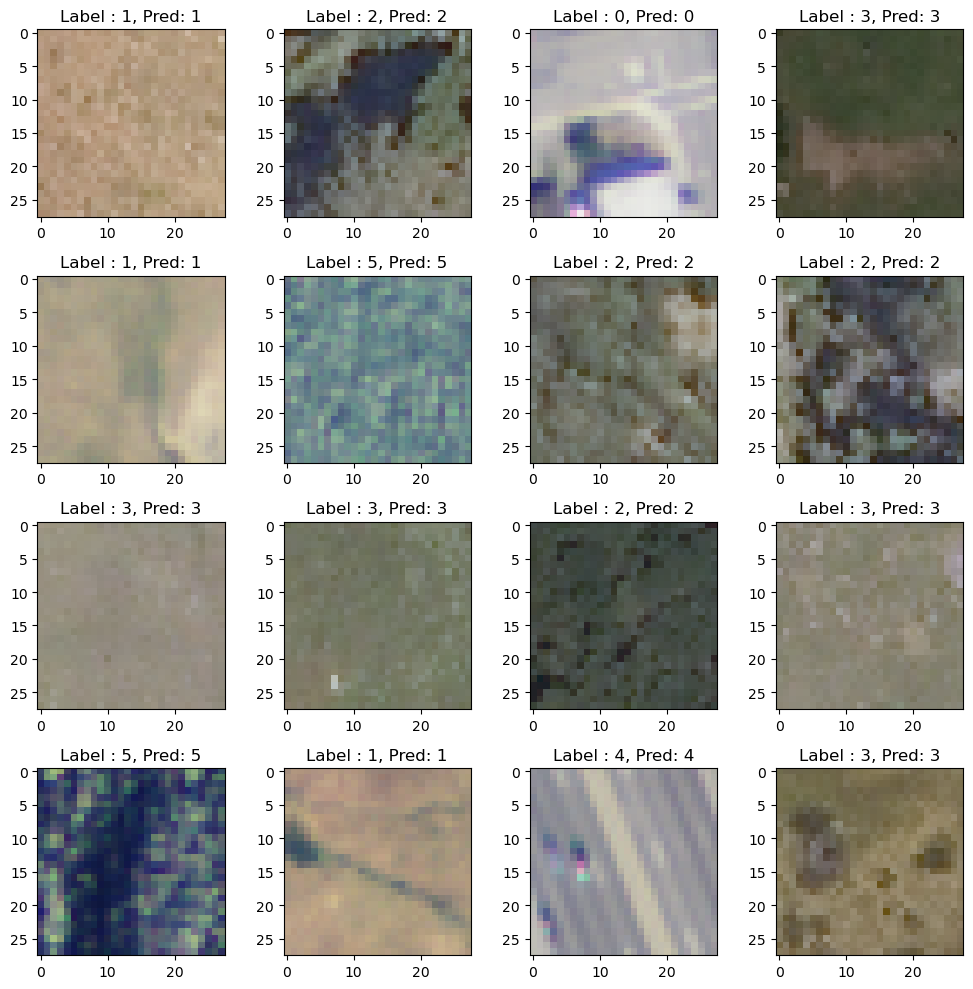

In [65]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(4,4, figsize=(10,10))
ax = ax.ravel()

#Change the dimension to fit into the model
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

x_test, t_test = next(iter(test_loader))
print('t_test.shape: ',t_test.shape)
print('x_test.shape: ',x_test.shape)
# t_test = test_labels.transpose()

cnn.eval()
with torch.no_grad():

    # Retrieve output from the image
    # idx_to_plot = 2
    count=0
    for idx_to_plot in range(16):
        image = x_test[idx_to_plot,:,:,:]
        image_orig = image.clone().permute(1,2,0)
        image = torch.FloatTensor(image).to('cuda')

        # Make input tensor require gradient
        image = image[None,:].requires_grad_()
        output = cnn(image)

        # Catch the output
        _, predicted = torch.max(output.data, 1)

        ax[count].imshow(image_orig[:,:,0:3].numpy().astype(np.uint64))
        ax[count].set_title('Label : {}, Pred: {}'.format(str(np.argmax(t_test[idx_to_plot,:].numpy())),predicted.cpu().numpy()[0]))
        count+=1

    fig.tight_layout()